In [35]:
import torch
from torch import nn
from src.data import get_data
from src.models import get_encoder, get_decoder
from src.utils import softclip
from src.hessian import sampler
import yaml
from copy import deepcopy
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
import os


def get_model(encoder, decoder):
    
    net = deepcopy(encoder.encoder._modules)
    decoder = decoder.decoder._modules
    max_ = max([int(i) for i in net.keys()])
    for i in decoder.keys():
        net.update({f"{max_+int(i) + 1}": decoder[i]})

    return nn.Sequential(net)

In [36]:
path_ae = "../weights/mnist/ae_[use_var_dec=False]"
with open(f"{path_ae}/config.yaml") as file:
    config = yaml.full_load(file)
ae_encoder = get_encoder(config, latent_size=2)
ae_encoder.load_state_dict(torch.load(f"{path_ae}/encoder.pth"))


path_mcae = "../weights/mnist/mcdropout_ae"
with open(f"{path_mcae}/config.yaml") as file:
    config = yaml.full_load(file)
mcae_encoder = get_encoder(config, latent_size=2, dropout=config["dropout_rate"])
mcae_encoder.load_state_dict(torch.load(f"{path_mcae}/encoder.pth"))

path_vae = "../weights/mnist/vae_[use_var_dec=False]"
with open(f"{path_vae}/config.yaml") as file:
    config = yaml.full_load(file)
vae_encoder_mu = get_encoder(config, latent_size=2)
vae_encoder_mu.load_state_dict(torch.load(f"{path_vae}/mu_encoder.pth"))
vae_encoder_var = get_encoder(config, latent_size=2)
vae_encoder_var.load_state_dict(torch.load(f"{path_vae}/var_encoder.pth"))

#path_lae = "../weights/mnist/lae_elbo/[backend_layer]_[approximation_exact]_[no_conv_True]_[train_samples_10]_/"
#path_lae = "../weights/mnist/lae_elbo/[backend_layer]_[approximation_exact]_[no_conv_True]_[train_samples_1]_"
path_lae="../weights/mnist/lae_model_selection_7_may/weights_mnist_model_selection/1[backend_layer]_[approximation_exact]_[no_conv_True]_[train_samples_1]_"
with open(f"{path_lae}/config.yaml") as file:
    config = yaml.full_load(file)
lae_encoder = get_encoder(config, latent_size=2)
lae_decoder = get_decoder(config, latent_size=2)
lae_net = get_model(lae_encoder, lae_decoder).eval()
lae_net.load_state_dict(torch.load(f"{path_lae}/net.pth"))
hessian_approx = (
    sampler.BlockSampler()
    if config["approximation"] == "block"
    else sampler.DiagSampler()
)
h = torch.load(f"{path_lae}/hessian.pth")
sigma_q = hessian_approx.invert(h).cpu()

In [37]:
_, val_dataloader = get_data("mnist")
images, labels = [ ], [ ]

for batch in val_dataloader:
    x, y = batch
    images.append(x)
    labels.append(y)
images = torch.cat(images, 0)
labels = torch.cat(labels, 0)

n_select = 5 # select this many datapoints from each class

selected_images = torch.zeros(10*n_select, 1, 28, 28)
selected_labels = torch.zeros(10*n_select,)
eval_set_images = torch.zeros(images.shape[0]-10*n_select, 1, 28, 28)
eval_set_labels = torch.zeros(images.shape[0]-10*n_select, )

count = 0
for i in range(10):
    idx = torch.where(labels == i)[0]
    n = len(idx)
    rand_idx = torch.randperm(n)

    selected_images[i*n_select:(i+1)*n_select] = images[idx[rand_idx[:n_select]]]
    selected_labels[i*n_select:(i+1)*n_select] = labels[idx[rand_idx[:n_select]]]
    eval_set_images[count:count+len(rand_idx[n_select:])] = images[idx[rand_idx[n_select:]]]
    eval_set_labels[count:count+len(rand_idx[n_select:])] = labels[idx[rand_idx[n_select:]]]

    count += len(rand_idx[n_select:])

# just for testing purpose
eval_set_images = eval_set_images[:1000]
eval_set_labels = eval_set_labels[:1000]

print(selected_images.shape)
print(selected_labels.shape)
print(eval_set_images.shape)
print(eval_set_labels.shape)


torch.Size([50, 1, 28, 28])
torch.Size([50])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


In [38]:
def get_encoding_ae(data, n=1):
    return ae_encoder(data)

print('standard ae')
print(get_encoding_ae(images[:1]))

def get_encoding_mcae(data, n=1):
    return torch.cat([mcae_encoder(data) for _ in range(n)], 0)

print('monte-carlo ae')
print(get_encoding_mcae(images[:1], n=2))

def get_encoding_vae(data, n=1):
    mu = vae_encoder_mu(data)
    sigma = torch.exp(softclip(vae_encoder_var(data), min=-3))
    return torch.cat([mu + torch.randn_like(sigma) * sigma for _ in range(n)])

print('vae')
print(get_encoding_vae(images[:1], n=2))

def get_encoding_lae(data, n=1, layer=5):
    embeddings = [ ]
    def fw_hook_get_latent(module, input, output):
        embeddings.append(output.detach().cpu())
    temp = deepcopy(lae_net)
    temp[layer].register_forward_hook(fw_hook_get_latent)

    mu_q = parameters_to_vector(temp.parameters())
    sample = hessian_approx.sample(mu_q, sigma_q, n_samples=n)
    for i in range(n):
        vector_to_parameters(sample[i], temp.parameters())
        _ = temp(data)
    return torch.cat(embeddings, 0)

print('lae')
print(get_encoding_lae(images[:1], n=2))

def gen_encoding_lae5(data, n=1):
    return get_encoding_lae(data, n=n, layer=5)

def gen_encoding_lae3(data, n=1):
    return get_encoding_lae(data, n=n, layer=3)

def gen_encoding_lae7(data, n=1):
    return get_encoding_lae(data, n=n, layer=7)



standard ae
tensor([[-8.9853, -2.1847]], grad_fn=<AddmmBackward0>)
monte-carlo ae
tensor([[-11.7726,   9.0926],
        [-12.8760,   6.9316]], grad_fn=<CatBackward0>)
vae
tensor([[ 1.5315, -0.8165],
        [-0.4371, -0.9594]], grad_fn=<CatBackward0>)
lae
tensor([[0.7303, 1.1691],
        [0.9279, 1.1496]])


In [30]:
z_grid = torch.meshgrid([torch.linspace(-20, 20, 200), torch.linspace(-20, 20, 200)])
z_grid = torch.stack(z_grid, 0).reshape(2, -1).T

names = ['ae', 'mcae', 'vae', 'lae']
scales = [1, 2, 5, 10, 20]
fig, ax = plt.subplots(4, len(scales), figsize=(20, 10))
res_mean, res_std = [], []
reps = 5
for i, (name, encoder) in enumerate(zip(names, [get_encoding_ae, get_encoding_mcae, get_encoding_vae, get_encoding_lae])):
    eval_data = torch.cat([encoder(d) for d in eval_set_images], 0)
    res_mean.append([ ])
    res_std.append([ ])
    for j, s in enumerate(scales):
        print(encoder, s)
        res = [ ]
        for r in range(reps):
            train_data = torch.cat([encoder(d, s) for d in selected_images], 0)
            train_labels = selected_labels.repeat_interleave(s) if name != 'ae' else selected_labels
            #classifier = KNeighborsClassifier(n_neighbors=2)
            classifier = GridSearchCV(
                KNeighborsClassifier(),
                {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
                cv=3,
                refit=True,
            )
            classifier.fit(train_data.detach().numpy(), train_labels.detach().numpy())
            preds = classifier.predict(eval_data.detach().numpy())
            acc = (preds == eval_set_labels.numpy()).mean()
            res.append(acc)

        res_mean[-1].append(np.mean(res))
        res_std[-1].append(np.std(res))

        preds_grid = classifier.predict(z_grid.numpy())
        ax[i, j].contourf(
            z_grid[:,0].reshape(100, 100),
            z_grid[:,1].reshape(100, 100),
            preds_grid.reshape(100, 100)
            alpha=0.1
        )
        ax[i, j].scatter(eval_data[:,0], eval_data[:, 1], c=eval_set_labels)
res_mean = np.asarray(res_mean)
res_std = np.asarray(res_std)

C:\Users\nsde\Anaconda3\envs\laplace\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


NameError: name 'get_encoding_ae' is not defined

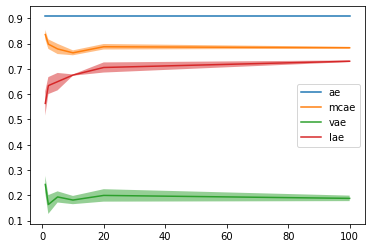

In [42]:
fig = plt.figure()
for i, name in enumerate(names):
    plt.plot(scales, res_mean[i], label=name)
    plt.fill_between(scales, res_mean[i] + res_std[i], res_mean[i] - res_std[i], alpha=0.5)

plt.legend()

In [34]:
res_m, res_s = [ ], [ ]
base_path = "..\weights\mnist\lae_model_selection_7_may\weights_mnist_model_selection"
for folder in os.listdir(base_path):
    res_m.append([ ])
    res_s.append([ ])
    with open(f"{base_path}/{folder}/config.yaml") as file:
        config = yaml.full_load(file)
    lae_encoder = get_encoder(config, latent_size=2)
    lae_decoder = get_decoder(config, latent_size=2)
    lae_net = get_model(lae_encoder, lae_decoder).eval()
    lae_net.load_state_dict(torch.load(f"{base_path}/{folder}/net.pth"))
    hessian_approx = (
        sampler.BlockSampler()
        if config["approximation"] == "block"
        else sampler.DiagSampler()
    )
    h = torch.load(f"{base_path}/{folder}/hessian.pth")
    sigma_q = hessian_approx.invert(h).cpu()

    def get_encoding_lae(data, n=1, layer=5):
        embeddings = [ ]
        def fw_hook_get_latent(module, input, output):
            embeddings.append(output.detach().cpu())
        temp = deepcopy(lae_net)
        temp[layer].register_forward_hook(fw_hook_get_latent)

        mu_q = parameters_to_vector(temp.parameters())
        sample = hessian_approx.sample(mu_q, sigma_q, n_samples=n)
        for i in range(n):
            vector_to_parameters(sample[i], temp.parameters())
            _ = temp(data)
        return torch.cat(embeddings, 0)

    eval_data = torch.cat([get_encoding_lae(d.unsqueeze(0)) for d in eval_set_images], 0)
    for s in [1, 2, 5, 10, 20]:
        res = [ ]
        for r in range(3):
            train_data = torch.cat([get_encoding_lae(d.unsqueeze(0), s) for d in selected_images], 0)
            train_labels = selected_labels.repeat_interleave(s)
            classifier = GridSearchCV(
                KNeighborsClassifier(),
                {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
                cv=2,
                refit=True,
            )
            classifier.fit(train_data.detach().numpy(), train_labels.detach().numpy())
            preds = classifier.predict(eval_data.detach().numpy())
            acc = (preds == eval_set_labels.numpy()).mean()
            res.append(acc)
        res_m[-1].append(np.mean(res))
        res_s[-1].append(np.std(res))

print(res_m)
print(res_s)


[[0.7353333333333333, 0.7303333333333333, 0.811, 0.819, 0.8053333333333335], [0.8436666666666667, 0.8450000000000001, 0.8583333333333333, 0.8196666666666665, 0.8113333333333334], [0.8850000000000001, 0.8403333333333333, 0.8373333333333334, 0.8096666666666666, 0.8103333333333333], [0.9053333333333334, 0.9166666666666666, 0.9136666666666667, 0.8636666666666667, 0.88], [0.859, 0.757, 0.8559999999999999, 0.8553333333333333, 0.8396666666666667]]
[[0.07352248333370928, 0.0634577724860311, 0.007118052168020829, 0.007788880963698574, 0.00368178700572909], [0.039684869772860384, 0.024711670657134206, 0.007845734863959886, 0.006548960901462796, 0.00464279609239466], [0.010801234497346443, 0.01405544576153869, 0.016213848676020427, 0.037809463835864615, 0.00543650214343333], [0.022216110270602198, 0.0026246692913372725, 0.0024944382578492965, 0.017133463034528545, 0.02177154105707726], [0.029631064780058135, 0.052198339692624954, 0.018493242008906945, 0.008993825042154702, 0.004496912521077351]]


In [27]:
get_encoding_lae(selected_images[0].unsqueeze(0), s)

tensor([[1.2062, 0.6500],
        [1.2406, 0.7277],
        [1.2293, 0.7060],
        [1.1829, 0.6542],
        [1.2076, 0.6943],
        [1.2203, 0.7586],
        [1.1422, 0.6292],
        [1.1810, 0.7095],
        [1.1409, 0.7560],
        [1.2680, 0.6393]])